
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
len(fmnist_dataset_train)

60000

In [7]:
for img, label in train_loader:
    print(img.shape)
#    print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
from torch import nn, optim
import torch.nn.functional as F
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_shape, input_shape),      
      nn.ReLU(),
      nn.Linear(input_shape, 32),
      nn.ReLU(),
      nn.Linear(32, num_classes)
    )
        # Dropout module with 0.1 drop probability
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.layers(x), dim=1)
        return x

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                   [-1, 32]          25,120
              ReLU-5                   [-1, 32]               0
            Linear-6                   [-1, 10]             330
Total params: 640,890
Trainable params: 640,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.44
Estimated Total Size (MB): 2.47
----------------------------------------------------------------


In [10]:
model = TinyNeuralNetwork().to(device)
criterion = nn.NLLLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in train_loader:
        opt.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        opt.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_loader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(train_loader.dataset)
        test_loss = tot_test_loss / len(test_loader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset)))

Epoch: 1/20..  Training Loss: 0.004..  Test Loss: 0.002..  Test Accuracy: 0.849
Epoch: 2/20..  Training Loss: 0.003..  Test Loss: 0.002..  Test Accuracy: 0.861
Epoch: 3/20..  Training Loss: 0.003..  Test Loss: 0.001..  Test Accuracy: 0.863
Epoch: 4/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.867
Epoch: 5/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.876
Epoch: 6/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.879
Epoch: 7/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.876
Epoch: 8/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.882
Epoch: 9/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.886
Epoch: 10/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.875
Epoch: 11/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.885
Epoch: 12/20..  Training Loss: 0.002..  Test Loss: 0.001..  Test Accuracy: 0.889
Epoch: 13/20..  Training Loss: 0.002.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [11]:
from collections import OrderedDict
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self,  n_layers, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        modules = []
        dim = 800
        dim2 = input_shape
        for i in range(n_layers):
            dim = dim - 50
            modules.append(nn.Linear(dim2, dim))
            modules.append(nn.ReLU())
            dim2 = dim
            if i == n_layers-1:
                modules.append(nn.Linear(dim, dim2))
        self.layers = nn.Sequential(*modules)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)        
        x = F.log_softmax(self.layers(x), dim=1)
        return x



In [12]:
torchsummary.summary(OverfittingNeuralNetwork(n_layers = 10).to(device), (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 750]         588,750
              ReLU-2                  [-1, 750]               0
            Linear-3                  [-1, 700]         525,700
              ReLU-4                  [-1, 700]               0
            Linear-5                  [-1, 650]         455,650
              ReLU-6                  [-1, 650]               0
            Linear-7                  [-1, 600]         390,600
              ReLU-8                  [-1, 600]               0
            Linear-9                  [-1, 550]         330,550
             ReLU-10                  [-1, 550]               0
           Linear-11                  [-1, 500]         275,500
             ReLU-12                  [-1, 500]               0
           Linear-13                  [-1, 450]         225,450
             ReLU-14                  [

In [13]:
len(fmnist_dataset_train)

60000

In [14]:
from sklearn.metrics import accuracy_score

In [42]:
batch_indices = list(range(0, len(fmnist_dataset_train), 20))
train_subset = torch.utils.data.Subset(fmnist_dataset_train, batch_indices)
train_loader_subset = torch.utils.data.DataLoader(train_subset, batch_size=30, shuffle=True, num_workers=2)

In [28]:
def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(n_epochs):
        train_loss_epoch = []
        test_loss_epoch = []
        train_accuracy_epoch = []
        test_accuracy_epoch = []
        model.train(True)
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(X_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()
            train_loss_epoch.append(loss.item())
            train_accuracy_epoch.append(accuracy_score(np.argmax(preds.detach().numpy(), axis=1), y_batch.detach().numpy()))
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)
                test_loss_epoch.append(loss_func(preds, y_batch.long()).item())
                test_accuracy_epoch.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
        train_loss.append(np.mean(train_loss_epoch))
        test_loss.append(np.mean(test_loss_epoch))
        train_accuracy.append(np.mean(train_accuracy_epoch))
        test_accuracy.append(np.mean(test_accuracy_epoch))
    return train_loss, train_accuracy, test_loss, test_accuracy

In [29]:
n_layer = 10
train_loss_layer, train_accuracy_layer, test_loss_layer, test_accuracy_layer = [], [], [], []
for layer in range(1,n_layer):

    model = OverfittingNeuralNetwork(n_layers = layer).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.6)
    loss_func = nn.NLLLoss()
    train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, train_loader_subset, test_loader, loss_func, opt, 100)
    train_loss_layer.append(np.mean(train_loss))
    train_accuracy_layer.append(np.mean(train_accuracy))
    test_loss_layer.append(np.mean(test_loss))
    test_accuracy_layer.append(np.mean(test_accuracy))
    print('n_layer', layer)
    print('np.mean(test_accuracy)', np.mean(test_accuracy))
    print('np.mean(test_loss)', np.mean(test_loss))
    print('np.mean(train_accuracy)', np.mean(train_accuracy))
    print('np.mean(train_loss)', np.mean(train_loss))

n_layer 1
np.mean(test_accuracy) 0.8137626953125
np.mean(test_loss) 0.5635173862501979
np.mean(train_accuracy) 0.8900966666666668
np.mean(train_loss) 0.3377752610519529
n_layer 2
np.mean(test_accuracy) 0.8089355468750002
np.mean(test_loss) 0.6194769159331917
np.mean(train_accuracy) 0.8970466666666667
np.mean(train_loss) 0.30942460547741496
n_layer 3
np.mean(test_accuracy) 0.7964003906249999
np.mean(test_loss) 0.6837040805630386
np.mean(train_accuracy) 0.8901233333333333
np.mean(train_loss) 0.32311907137356466
n_layer 4
np.mean(test_accuracy) 0.781322265625
np.mean(test_loss) 0.7743035186082124
np.mean(train_accuracy) 0.8767166666666667
np.mean(train_loss) 0.36491447607065786
n_layer 5
np.mean(test_accuracy) 0.7524238281249999
np.mean(test_loss) 0.8882076537907124
np.mean(train_accuracy) 0.8471766666666667
np.mean(train_loss) 0.4540931488575531
n_layer 6
np.mean(test_accuracy) 0.7302177734374999
np.mean(test_loss) 0.991773480504751
np.mean(train_accuracy) 0.8252600000000001
np.mean(trai

In [30]:
def draw_plot_accuracy():
    plt.figure(figsize=(10, 10))
    plt.title("Accuracy vs layer")
    plt.xlabel("layer")
    plt.ylabel("accuracy")
    plt.plot(train_accuracy_layer, label='train data')
    plt.plot(test_accuracy_layer, label='test data')
    plt.legend()
    plt.show()

In [31]:
def draw_plot_loss():
    plt.figure(figsize=(10, 10))
    plt.title("Loss vs layer")
    plt.xlabel("layer")
    plt.ylabel("loss")
    plt.plot(train_loss_layer, label='train data')
    plt.plot(test_loss_layer, label='test data')    
    plt.legend()
    plt.show()

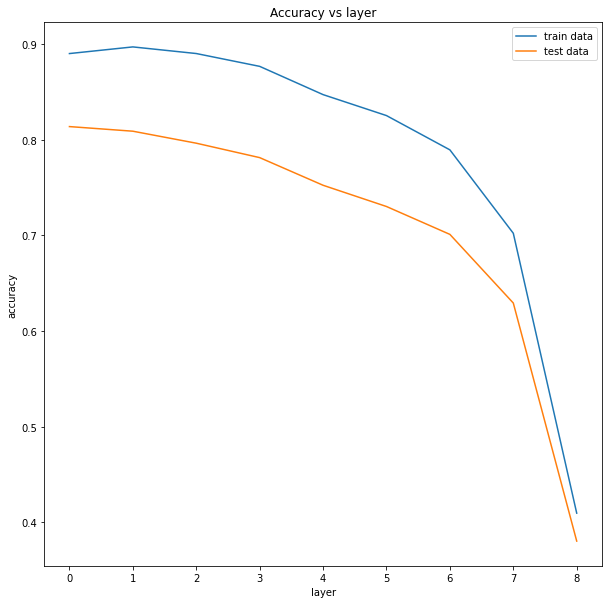

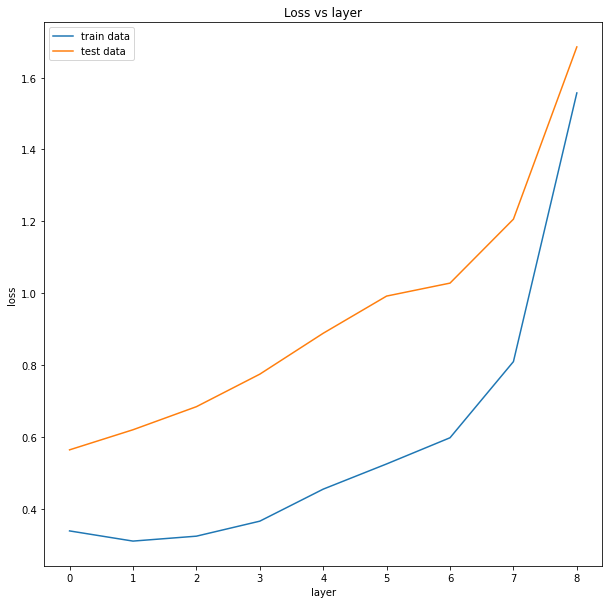

In [32]:
draw_plot_accuracy()
draw_plot_loss()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [44]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self,  n_layers, input_shape=28*28, num_classes=10, input_channels=1):
        super().__init__()
        modules = []
        dim = 800
        dim2 = input_shape
        for i in range(n_layers):
            dim = dim - 50
            modules.append(nn.Linear(dim2, dim))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.1))
            dim2 = dim
            modules.append(nn.Linear(dim, dim2)) 
            
        self.layers = nn.Sequential(*modules)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)        
        x = F.log_softmax(self.layers(x), dim=1)
        return x

In [45]:
torchsummary.summary(FixedNeuralNetwork(n_layers = 3).to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 750]         588,750
              ReLU-2                  [-1, 750]               0
           Dropout-3                  [-1, 750]               0
            Linear-4                  [-1, 750]         563,250
            Linear-5                  [-1, 700]         525,700
              ReLU-6                  [-1, 700]               0
           Dropout-7                  [-1, 700]               0
            Linear-8                  [-1, 700]         490,700
            Linear-9                  [-1, 650]         455,650
             ReLU-10                  [-1, 650]               0
          Dropout-11                  [-1, 650]               0
           Linear-12                  [-1, 650]         423,150
Total params: 3,047,200
Trainable params: 3,047,200
Non-trainable params: 0
---------------------------

In [51]:
n_layer = 10
train_loss_layer, train_accuracy_layer, test_loss_layer, test_accuracy_layer = [], [], [], []
for layer in range(1,n_layer):

    model = FixedNeuralNetwork(n_layers = layer).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.6)
    loss_func = nn.NLLLoss()
    train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, train_loader_subset, test_loader, loss_func, opt, 100)
    train_loss_layer.append(np.mean(train_loss))
    train_accuracy_layer.append(np.mean(train_accuracy))
    test_loss_layer.append(np.mean(test_loss))
    test_accuracy_layer.append(np.mean(test_accuracy))
    print('n_layer', layer)
    print('np.mean(test_accuracy)', np.mean(test_accuracy))
    print('np.mean(test_loss)', np.mean(test_loss))
    print('np.mean(train_accuracy)', np.mean(train_accuracy))
    print('np.mean(train_loss)', np.mean(train_loss))

n_layer 1
np.mean(test_accuracy) 0.7448046875000002
np.mean(test_loss) 0.8153444786891341
np.mean(train_accuracy) 0.7566508152173913
np.mean(train_loss) 0.8215770645191272
n_layer 2
np.mean(test_accuracy) 0.6716464843750001
np.mean(test_loss) 0.9886776489838957
np.mean(train_accuracy) 0.6716093466938406
np.mean(train_loss) 1.0052040122449397
n_layer 3
np.mean(test_accuracy) 0.5329501953125001
np.mean(test_loss) 1.4799487822800872
np.mean(train_accuracy) 0.5270288439764492
np.mean(train_loss) 1.506154757489761
n_layer 4
np.mean(test_accuracy) 0.39356640624999994
np.mean(test_loss) 1.9459263026043772
np.mean(train_accuracy) 0.3826006283967391
np.mean(train_loss) 1.9876158652206264
n_layer 5
np.mean(test_accuracy) 0.2339267578125
np.mean(test_loss) 2.362184926331043
np.mean(train_accuracy) 0.22356091485507248
np.mean(train_loss) 2.399948383371035
n_layer 6
np.mean(test_accuracy) 0.09992968749999999
np.mean(test_loss) 2.758422058820725
np.mean(train_accuracy) 0.09727340919384059
np.mean(tr

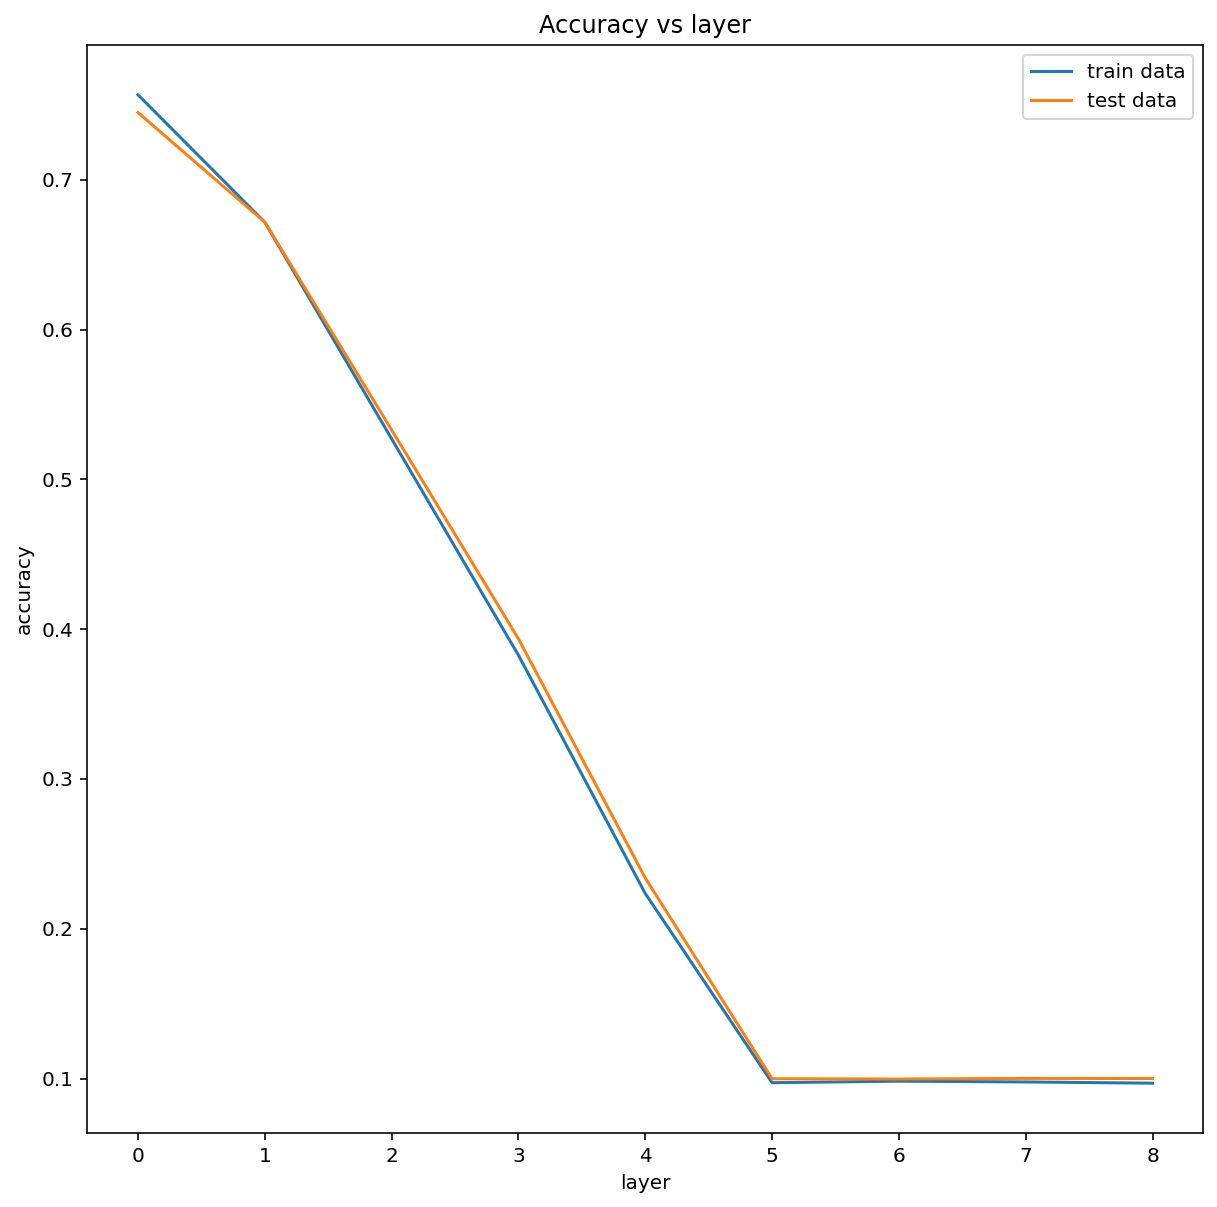

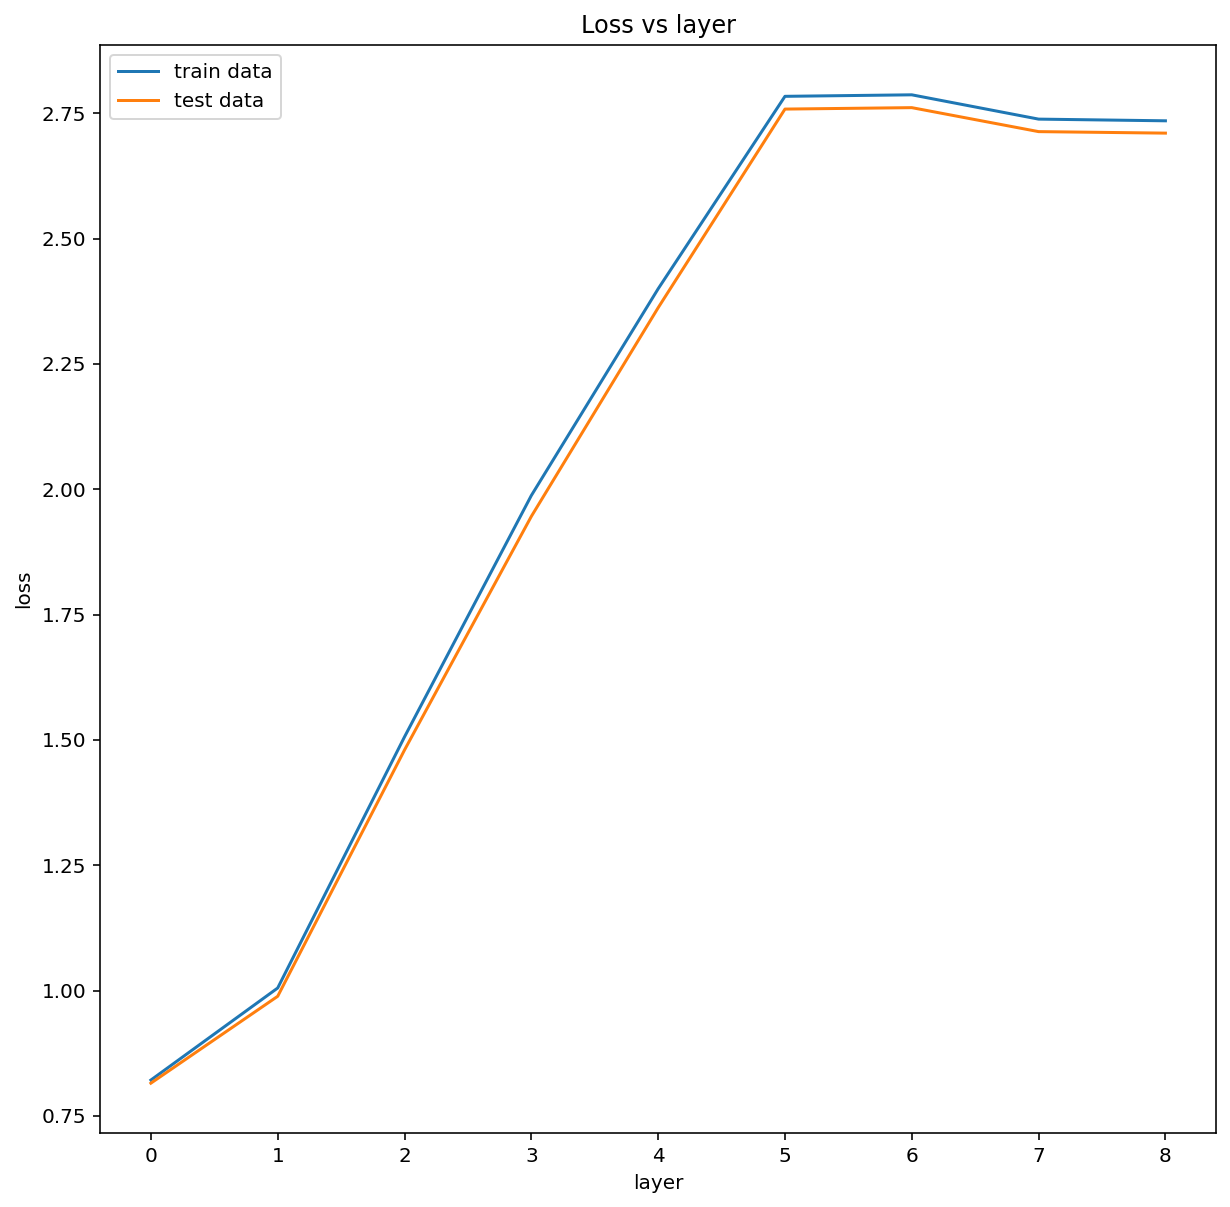

In [52]:
draw_plot_accuracy()
draw_plot_loss()

### Conclusions:
The preformance become poor, when we increase the complexity of the model. In task 2, in testing data we can see that the loss is higher much, despite that loss for training set shows good results. The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. In task 3, we do not see much difference of the loss in testing data. 